In [122]:
import seaborn as sns
from fill_and_map import fill_inds_trans, fill_econ, map_inds_sdg, sep_inds
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
# get data
fpath = Path('data_raw/SDG-DEA_indicators_V5_20200708.xlsx')
inds = fill_inds_trans(fpath)
inds_econ = fill_econ(fpath)
inds_map = map_inds_sdg(fpath)
inds_econ = inds_econ.loc[inds.index, :] # remove dropped countries from economic indicators as well
skip_inds, undes_inds, _ = sep_inds()

Removing countries with >=20.0% missing indicator values:
 AND    0.588235
ATG    0.392157
BHR    0.245098
BHS    0.313725
BRB    0.235294
BRN    0.235294
CPV    0.215686
CUB    0.245098
DMA    0.480392
ERI    0.313725
FSM    0.411765
GNB    0.235294
GNQ    0.294118
GRD    0.460784
KIR    0.450980
KNA    0.549020
LBY    0.294118
LCA    0.323529
LIE    0.735294
MCO    0.696078
MHL    0.529412
NRU    0.617647
PLW    0.578431
PRK    0.323529
SLB    0.205882
SMR    0.627451
SOM    0.254902
SSD    0.343137
STP    0.254902
SYC    0.284314
SYR    0.245098
TKM    0.254902
TLS    0.245098
TON    0.284314
TUV    0.598039
VCT    0.382353
WSM    0.245098
dtype: float64

Removing indicators with >=35.0% missing country values:
 sdg2_foodinsec_inv    0.487179
sdg14_fishstocks      0.403846
dtype: float64


In [7]:
econ_map = {1:'Expenditure_on_social_protection', 
            2:'Expenditure_on_agriculture_fishing_forestry__hunting', 
            3:'Expenditure_on_health', 
            4:'Expenditure_on_education'}
combined_inds = pd.concat((inds, inds_econ), axis=1)

In [299]:
# # remove govex indicator
# inds_map[1] = [ii for ii in inds_map[1] if ii != 'sdg17_govex']
# combined_inds = combined_inds.drop(columns=['sdg17_govex'])

In [10]:
# cmap = np.divide([[140,107,177],
#                  [199,233,180],
#                  [158,188,218],
#                  [65,182,196]],255)
cmap = np.divide([[140,107,177],
                 [114,177,79],
                 [158,188,218],
                 [65,182,196]],255)

# Analysis of progress towards SDG1-SDG17

In [4]:
# load progress data
fpath = Path('data_raw/2019GlobalIndexResults - SDGI report.xlsx')
progress_raw = pd.read_excel(fpath,
                            sheet_name='SDR2019 Data',
                            usecols='B,QK:RA',
                            header=1,
                            index_col=0
                            )

In [5]:
# process data
income = inds_econ.loc[:,'Income Group in 2019'] # income categories
progress = progress_raw.loc[inds.index, :] # remove countries not considered in inds because of missing data
progress.columns = range(1,18) # rename columns
mean_progress = progress.groupby(income).mean()
mean_progress.index.name = None # remove index name
mean_progress = mean_progress.reindex(['LIC', 'LMIC', 'UMIC', 'HIC'])

# for ii in income.unique(): # fill nans with income category averages (not necessary if we want mean, and would fill nans with mean)
#     idx = income[income == ii].index
#     progress.loc[idx,:] = progress.loc[idx,:].fillna(progress.loc[idx,:].mean())


In [12]:
goals = ['Poverty',
        'Hunger',
        'Heath',
        'Education',
        'Gender equality',
        'Water and sanitation',
        'Energy',
        'Economic growth',
        'Infrastructure',
        'Inequality',
        'Cities and settlements',
        'Sustainable consumption',
        'Climate change',
        'Aquatic ecosystems',
        'Terrestrial ecosystems',
        'Peace and justice',
        'Partnerships']
goals_dict = {ii+1:nn for ii, nn in enumerate(goals)}

## Radial plot

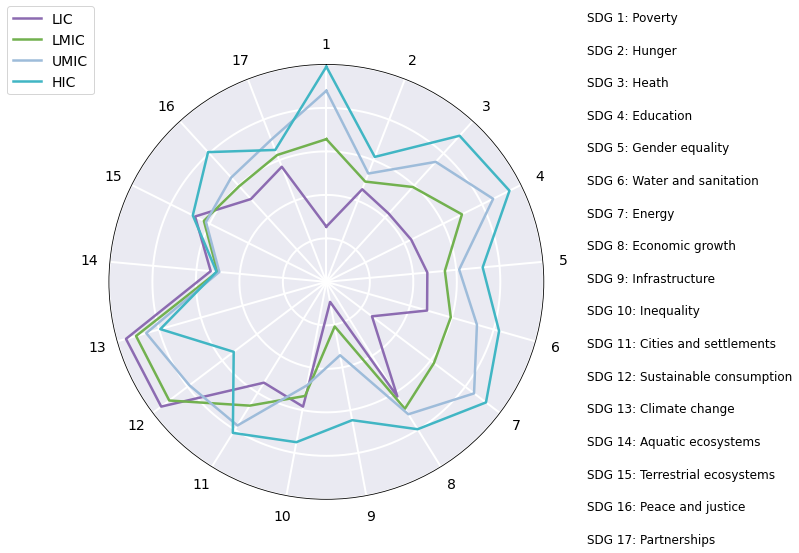

In [294]:
## Set up axis

# get radar angles
N = len(mean_progress.columns)
angles = [a/N*2*np.pi for a in range(N)]
angles += angles[:1] # to connect the last element back to the first

# initialise plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, polar=True)

# first axis on top
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# one axis per variable, plus labels
plt.xticks(angles[:-1], mean_progress.columns, fontsize=14)



## Add data
ii = 'LIC'
for ii, inc in enumerate(mean_progress.index):
    values = mean_progress.loc[inc, :].tolist()
    values += values[:1]
    ax.plot(angles, values, label=inc, color=cmap[ii], linewidth=2.5, zorder=2.5)
plt.legend(bbox_to_anchor=(-.25,1.15), loc=2, fontsize=14)

# ylabels
plt.ylim(0,100)
# plt.yticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100'], color='k',fontsize=12)
plt.yticks([0, 20, 40, 60, 80, 100], ['', '', '', '', '', ''], color='k',fontsize=12)
ax.set_rlabel_position(0)

ax.tick_params(axis='x', which='major', pad=10)
ax.set_facecolor(np.divide([234, 234, 242], 255))
plt.grid(color='w', linewidth=2, zorder=2.5)

# add text
ystr = [''.join(('SDG ',str(s),': ',goals[ii])) for ii, s in enumerate(mean_progress.columns)]
yy = np.linspace(1.1,-0.1,17)
for ii in range(17):
    ax.text(1.1, yy[ii], ystr[ii], transform=ax.transAxes, fontsize=12)

# plt.savefig('figures/progress_rad_text_2.jpg', dpi=600)

In [278]:
ystr[0]

'SDG 1: Poverty'

## Vertical line plot

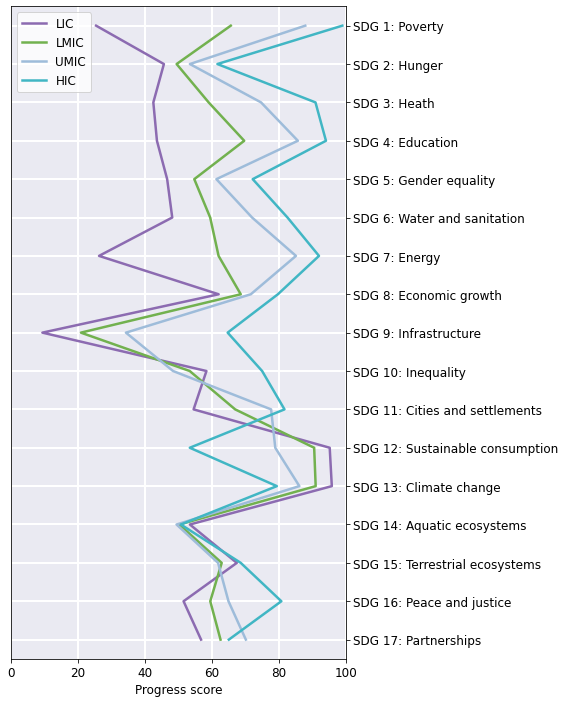

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(6,12))
ax.set_ylim(0.5,17.5)
ax.set_xlim(0,100)

for ii, inc in enumerate(mean_progress.index):
    plt.plot(mean_progress.loc[inc, :], mean_progress.columns[::-1], label=inc, linewidth=2.5, color=cmap[ii])
plt.legend(loc='best', fontsize=12)

# ticks and labels
ytick_loc = list(mean_progress.columns)
ytick_str = [''.join(('SDG ',str(s),': ',goals[ii])) for ii, s in enumerate(mean_progress.columns)]
plt.yticks(ytick_loc, ytick_str[::-1], fontsize=12)
ax.yaxis.tick_right()
plt.xticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100'], fontsize=12)
# plt.ylabel('SDG', fontsize=12)
plt.xlabel('Progress score', fontsize=12)



# background
ax.set_facecolor(np.divide([234, 234, 242], 255))
plt.grid(color='w', linewidth=2)

# plt.savefig('figures/progress_vert.jpg', bbox_inches='tight', dpi=600)

# Exploratory analysis of indicators

## Grouped box charts of indicators

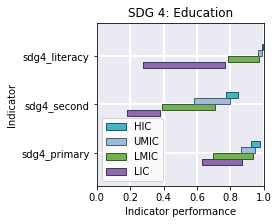

In [72]:
s = 4
# scale between 0 and 1
scaled_inds = (inds[inds_map[s]]-inds[inds_map[s]].min())/(inds[inds_map[s]].max()-inds[inds_map[s]].min())

# undesired indicators
undes_s = list(set(inds_map[s]) & set(undes_inds)) # undesired indicators for SDG s
scaled_inds[undes_s] = scaled_inds[undes_s] *-1 +1

# # add income column
# scaled_inds['Income Group in 2019'] = combined_inds['Income Group in 2019']
scaled_inds['Income Group in 2019'] = inds_econ['Income Group in 2019']

fig, ax = plt.subplots(1,1, figsize=(3, scaled_inds.shape[1]-1))
ax.set_xlim(0,1)
ind_pos = np.arange(scaled_inds.shape[1]-1)+0.5 # y position for each indicator
ww = 0.125 # box width

for ii, ind in enumerate(scaled_inds.columns[:-1]):

    for jj, inc in enumerate(['LIC', 'LMIC', 'UMIC', 'HIC']):
        cface = cmap[jj,:]
        cedge = cmap[jj,:]*.5
        data = scaled_inds.loc[:,ind][scaled_inds['Income Group in 2019'] == inc]
        boxprops=dict(facecolor=cface, edgecolor=cedge) # set colour of box
        medianprops = dict(linewidth=0) # hide median line
        
        pos = ind_pos[ii] + (jj-1.5)*ww
        ax.boxplot(data, vert=False, patch_artist=True, showcaps=False, showfliers=False, whis=0, medianprops=medianprops, boxprops=boxprops, positions=[pos], widths=ww, labels=[inc])
    
# set ytick positions and labels
ax.set_yticks(ind_pos)
ind_names = [str(nn) if nn not in undes_s else ''.join((str(nn),'*')) for nn in scaled_inds.columns[:-1]]
# ax.set_yticklabels(scaled_inds.columns[:-1])
ax.set_yticklabels(ind_names)

# format background and grid
ax.set_facecolor(np.divide([234, 234, 242], 255))
plt.grid(color='w', linewidth=2)
plt.title(''.join(('SDG ', str(s), ': ', goals_dict[s])))
plt.xlabel('Indicator performance')
plt.ylabel('Indicator')

# custom legend
patches = []
for ii, inc in enumerate(['HIC', 'UMIC', 'LMIC', 'LIC']):
    patches.append(mpatches.Patch(facecolor=cmap[3-ii, :], edgecolor=cmap[3-ii, :]*.5, label=inc))
plt.legend(handles=patches)

# plt.savefig('figures/ind_performance_sdg{0}.jpg'.format(s), bbox_inches='tight', dpi=600)

## Grouped box charts of indicators, combined

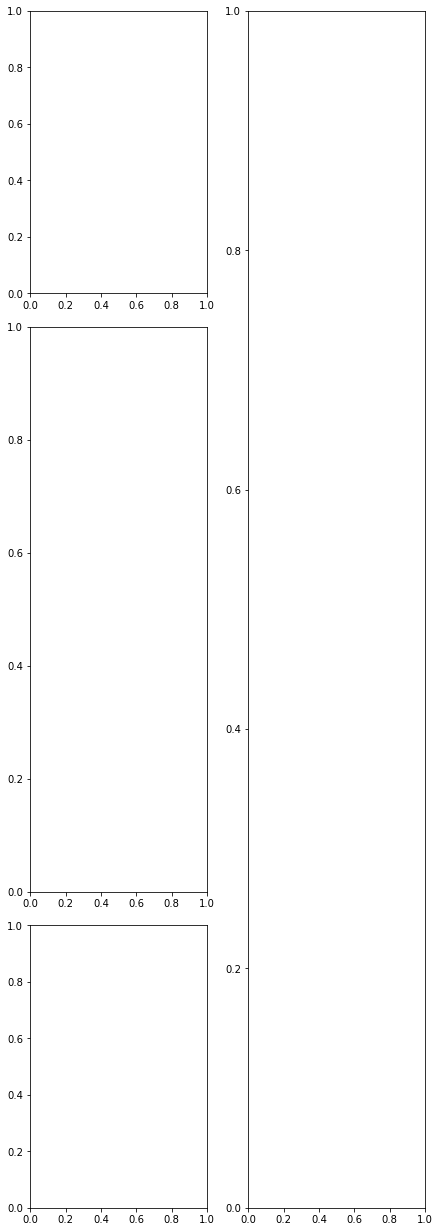

In [100]:
fig = plt.figure(constrained_layout=True, figsize=(6, 17))
gs = fig.add_gridspec(4,2)
axes = []
axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[1:3,0]))
axes.append(fig.add_subplot(gs[:,-1]))
axes.append(fig.add_subplot(gs[-1,0]))


In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(6, 17))
gs = fig.add_gridspec(4,2)

In [102]:
gs_data = {1:(0,0)}

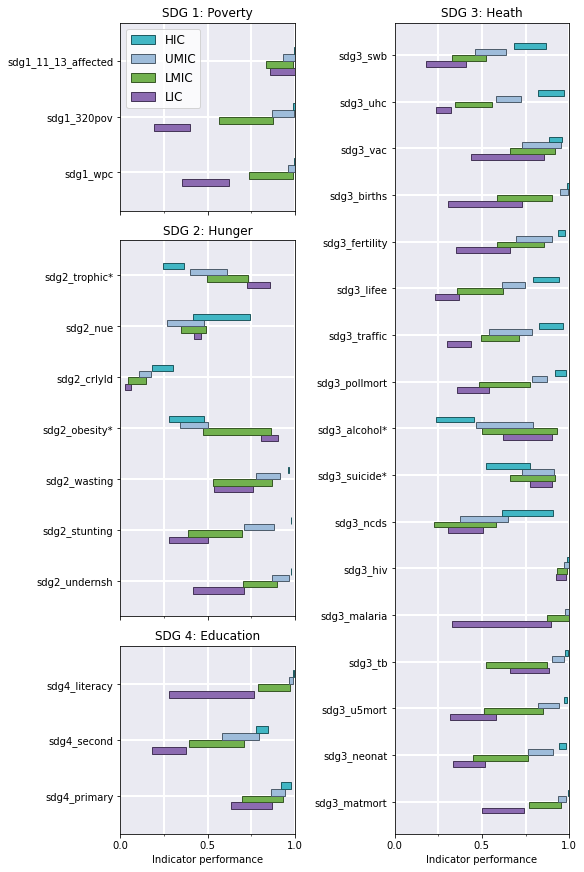

In [136]:
s = 4

fig = plt.figure(constrained_layout=True, figsize=(8, 12))
gs = fig.add_gridspec(4,2)
axes = []
axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[1:3,0], sharex=axes[0]))
axes.append(fig.add_subplot(gs[:,-1], sharex=axes[0]))
axes.append(fig.add_subplot(gs[-1,0], sharex=axes[0]))

for s in range(1,5):
    # scale between 0 and 1
    scaled_inds = (inds[inds_map[s]]-inds[inds_map[s]].min())/(inds[inds_map[s]].max()-inds[inds_map[s]].min())

    # undesired indicators
    undes_s = list(set(inds_map[s]) & set(undes_inds)) # undesired indicators for SDG s
    scaled_inds[undes_s] = scaled_inds[undes_s] *-1 +1

    # # add income column
    # scaled_inds['Income Group in 2019'] = combined_inds['Income Group in 2019']
    scaled_inds['Income Group in 2019'] = inds_econ['Income Group in 2019']

    # fig, ax = plt.subplots(1,1, figsize=(3, scaled_inds.shape[1]-1))
    axes[s-1].set_xlim(0,1)
    ind_pos = np.arange(scaled_inds.shape[1]-1)+0.5 # y position for each indicator
    ww = 0.125 # box width

    for ii, ind in enumerate(scaled_inds.columns[:-1]):

        for jj, inc in enumerate(['LIC', 'LMIC', 'UMIC', 'HIC']):
            cface = cmap[jj,:]
            cedge = cmap[jj,:]*.5
            data = scaled_inds.loc[:,ind][scaled_inds['Income Group in 2019'] == inc]
            boxprops=dict(facecolor=cface, edgecolor=cedge) # set colour of box
            medianprops = dict(linewidth=0) # hide median line
            
            pos = ind_pos[ii] + (jj-1.5)*ww
            axes[s-1].boxplot(data, vert=False, patch_artist=True, showcaps=False, showfliers=False, whis=0, medianprops=medianprops, boxprops=boxprops, positions=[pos], widths=ww, labels=[inc])
        
    # set ytick positions and labels
    axes[s-1].set_yticks(ind_pos)
    ind_names = [str(nn) if nn not in undes_s else ''.join((str(nn),'*')) for nn in scaled_inds.columns[:-1]]
    # ax.set_yticklabels(scaled_inds.columns[:-1])
    axes[s-1].set_yticklabels(ind_names)

    # format background and grid
    axes[s-1].set_facecolor(np.divide([234, 234, 242], 255))
    axes[s-1].grid(color='w', linewidth=2, which='both')
    axes[s-1].xaxis.set_major_locator(MultipleLocator(0.5))
    axes[s-1].xaxis.set_minor_locator(MultipleLocator(0.25))

    axes[s-1].set_title(''.join(('SDG ', str(s), ': ', goals_dict[s])))

    # axes[s-1].set_xlabel('Indicator performance')
    # plt.ylabel('Indicator')

    if axes[s-1].is_last_row():
        axes[s-1].set_xlabel('Indicator performance')
        # axes[s-1].set_xticks([0, 0.25, 0.5, 0.75, 1])
    else:
        plt.setp(axes[s-1].get_xticklabels(), visible=False)

# custom legend
patches = []
for ii, inc in enumerate(['HIC', 'UMIC', 'LMIC', 'LIC']):
    patches.append(mpatches.Patch(facecolor=cmap[3-ii, :], edgecolor=cmap[3-ii, :]*.5, label=inc))
axes[0].legend(handles=patches, fontsize=12)

plt.savefig('figures/ind_performance_all.jpg', bbox_inches='tight', dpi=600)

In [97]:
ax

4

# Bivariate analysis of SDG1-SDG4

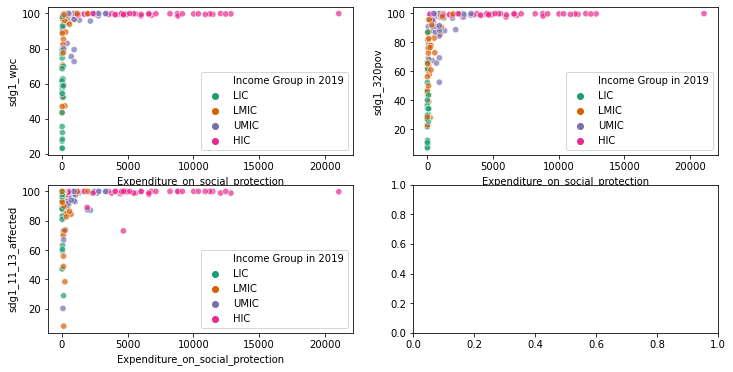

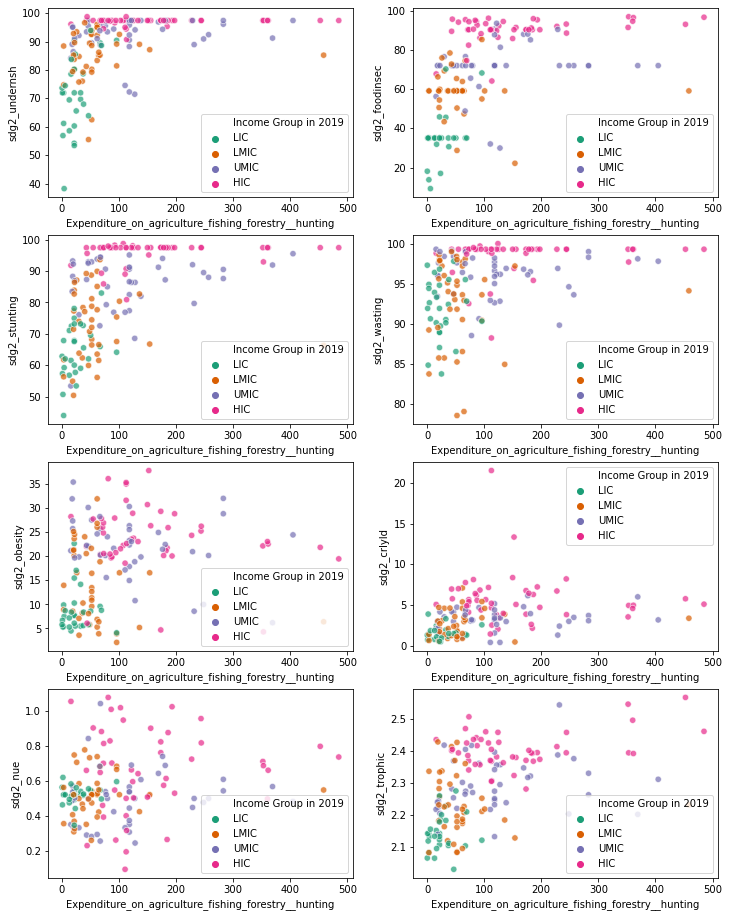

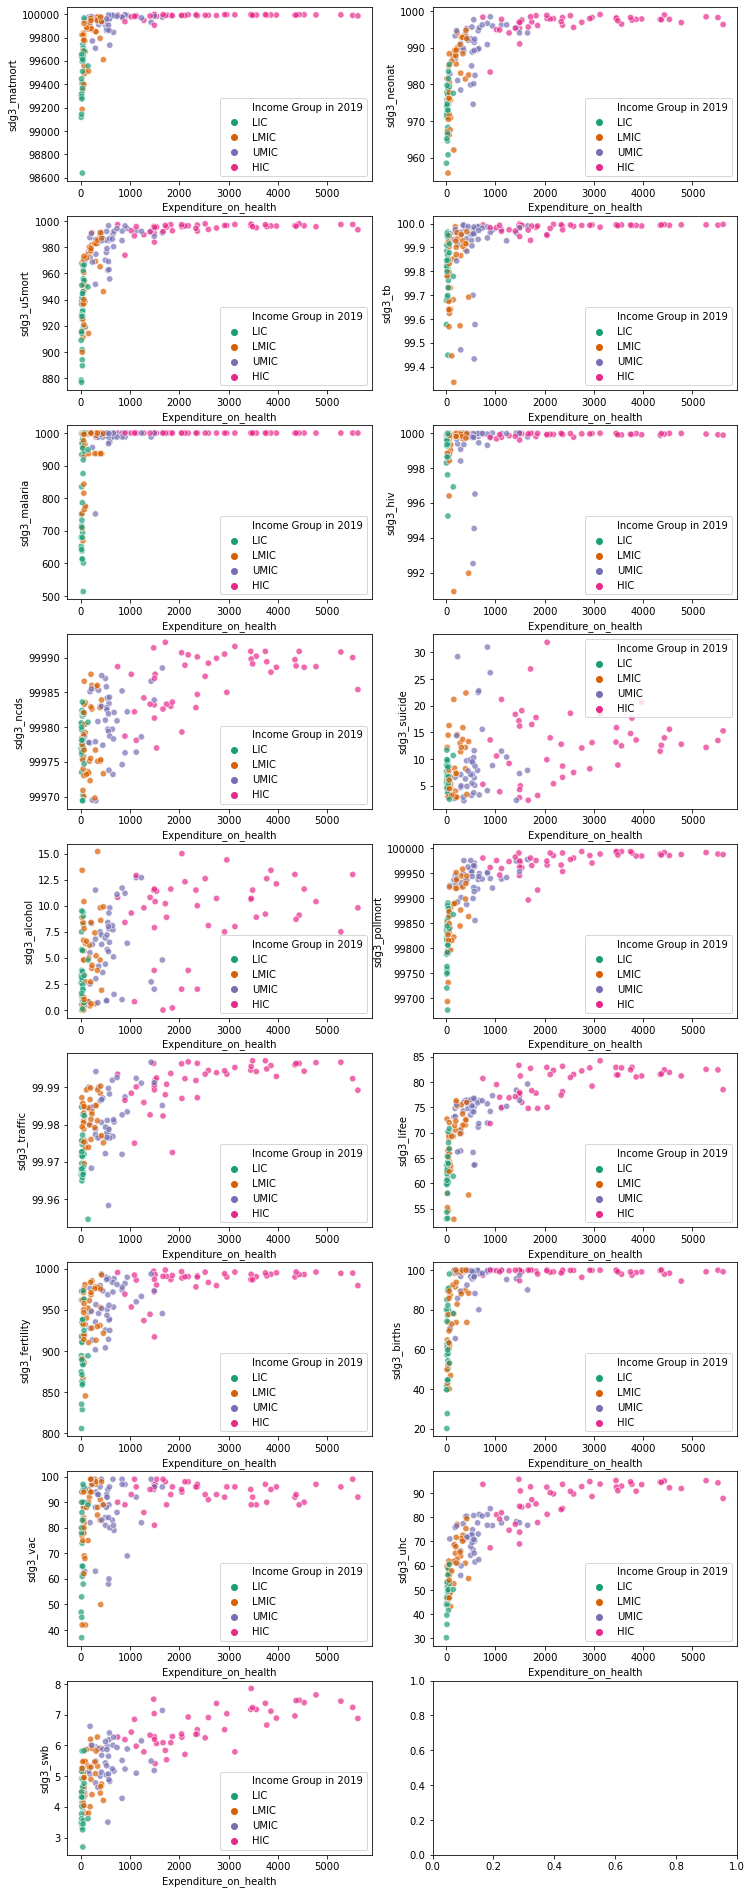

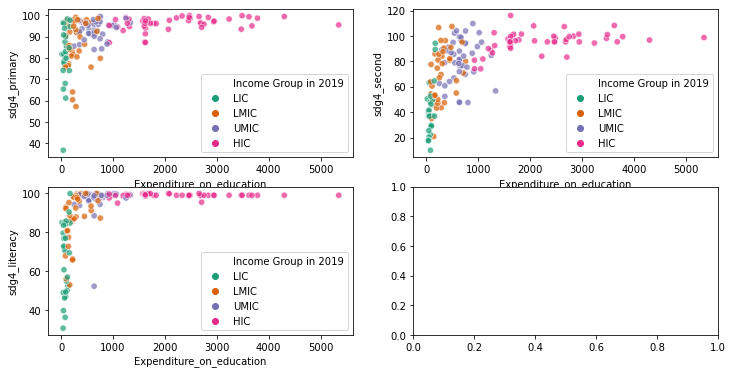

In [124]:
for s in range(1,5):
    n_inds = len(inds_map[s])
    fig, ax = plt.subplots(int(np.ceil(n_inds/2)), 2, figsize=(12, 2*n_inds))
    for ii in range(n_inds):
        row = int(np.floor(ii/2))
        col = int(np.mod(ii, 2))
        # ax[ii].set(xscale='log')
        sns.scatterplot(data=combined_inds, x=econ_map[s], y=inds_map[s][ii], hue='Income Group in 2019', ax=ax[row][col], palette='Dark2', s=40, alpha=0.7)

    # plt.savefig('figures/eda_sdg{0}.jpg'.format(s), dpi=600)
    

In [12]:
inds_econ

,Income Group in 2019,Expenditure_on_agriculture_fishing_forestry__hunting,Expenditure_on_health,Expenditure_on_education,Expenditure_on_social_protection,Rest_of_COFOG_not_defined
AFG,LIC,32.854809,38.766016,84.469083,41.634744,858.268464
AGO,LMIC,35.866862,90.016053,140.563529,145.410547,1281.102611
ALB,UMIC,90.889873,389.929225,422.968696,1259.465270,1780.542167
ARE,HIC,112.624374,1487.603255,1086.198591,1295.271361,15541.442620
ARG,HIC,15.939236,1277.599635,1246.168402,2714.899224,4087.726761
...,...,...,...,...,...,...
VUT,LMIC,20.509251,62.892077,147.650786,18.867623,897.457112
YEM,LIC,25.186906,34.061988,82.089434,28.782583,299.547332
ZAF,UMIC,66.570529,568.867865,779.634662,699.530334,3623.676831
ZMB,LMIC,46.691543,59.728355,163.985253,7.026865,670.187615
